# Support Vector Machine Model for a Regression 


### Problem statement -"Develop a regression model to predict garment employee productivity. Accurate predictions will optimize workforce planning and enhance production efficiency. "

In [65]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

In [66]:
 # Defining a flexible file path for the ease of new user
file_path = input("Enter path to CSV file: ")
df = pd.read_csv(file_path)

df.head() 

Enter path to CSV file:  C:/Users/Arpit Mahapatra/Desktop/MLDM Coursework 2025/mlmavericks_coursework/data/processed/tree_model_ready.csv


,date,team,targeted_productivity,smv,wip,over_time,incentive,no_of_style_change,no_of_workers,actual_productivity,...,idle_ratio,day_num,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,department_label,quarter_label
0,2015-01-01,8,0.80,26.16,1108.0,7080,98,0,59.0,0.940725,...,0.0,3,False,False,False,True,False,False,1,0
1,2015-01-01,1,0.75,3.94,1039.0,960,0,0,8.0,0.886500,...,0.0,3,False,False,False,True,False,False,0,0
2,2015-01-01,11,0.80,11.41,968.0,3660,50,0,30.5,0.800570,...,0.0,3,False,False,False,True,False,False,1,0
3,2015-01-01,12,0.80,11.41,968.0,3660,50,0,30.5,0.800570,...,0.0,3,False,False,False,True,False,False,1,0
4,2015-01-01,6,0.80,25.90,1170.0,1920,50,0,56.0,0.800382,...,0.0,3,False,False,False,True,False,False,1,0


In [67]:
# Checking for missing values in target variable 
df["actual_productivity"].isnull().sum()

np.int64(0)

### Preprocessing for better results of SVR

* As we can clearly see that the date column is a time stamp and doesnt carry any importance for our problem statement as we arent doing time-series analysis

* Also as per the dataset we can see alot of boolean values which the SVR cannot understand hence we need to convert the boolenan into numeric

In [68]:
 # Droping the date column 
df.drop(columns=['date'], inplace=True)

# Encoding categorical features
bool_cols = df.select_dtypes(include=["bool"]).columns
df[bool_cols] = df[bool_cols].astype(int)

In [69]:
# Checking that all the data types to spot out whether there are any non numeric features
print(df.dtypes)

team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
overtime_bin              object
wip_log                  float64
idle_men_ratio           float64
idle_ratio               float64
day_num                    int64
day_Monday                 int64
day_Saturday               int64
day_Sunday                 int64
day_Thursday               int64
day_Tuesday                int64
day_Wednesday              int64
department_label           int64
quarter_label              int64
dtype: object


**As we can see that there is a object datatype of overtime bin column lets go and see how does the column look like**

In [70]:
 # Checking for different types of values in overtime bin
print(df['overtime_bin'].value_counts())

overtime_bin
5001-10000     386
1001-2000      245
2001-5000      238
10001-20000    145
501-1000       141
0-500           41
20001+           1
Name: count, dtype: int64


These ranges are taken as objects by the python kernel so we need to one hot encode all these objects so that we can get best results with SVR which only deals with numeric columns

In [71]:
 # One-hot encoding 'overtime_bin' 
if "overtime_bin" in df.columns:
    df = pd.get_dummies(df, columns=["overtime_bin"], drop_first=True)

In [72]:
 # Displaying the summery of the target variable 
print("Summary statistics:")
print(df['actual_productivity'].describe())

Summary statistics:
count    1197.000000
mean        0.735091
std         0.174488
min         0.233705
25%         0.650307
50%         0.773333
75%         0.850253
max         1.120437
Name: actual_productivity, dtype: float64


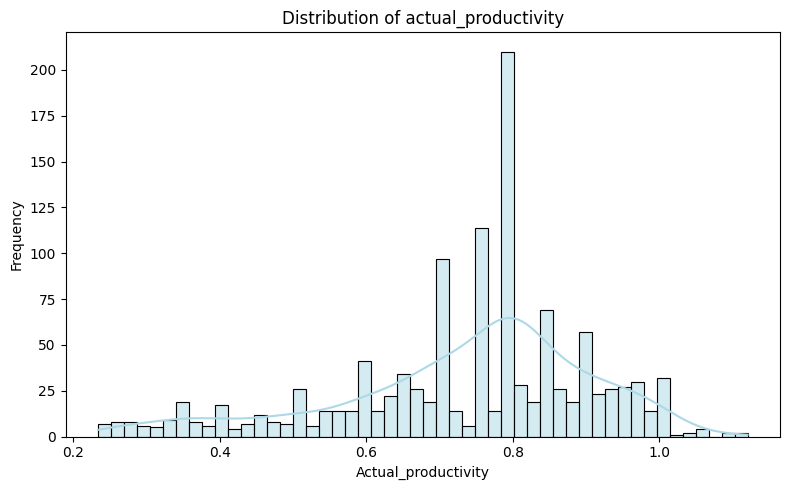

In [73]:
# Checking the distribution of target variable 
plt.figure(figsize=(8, 5))
sns.histplot(df['actual_productivity'], bins=50, kde=True, color='lightblue')
plt.title("Distribution of actual_productivity")
plt.xlabel("Actual_productivity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Target Variable Exploration: actual_productivity

* The distribution is centered around 0.8, with a clear dominant peak, suggesting many tickets achieved similar productivity levels.

* The distribution exhibits a slight right skew, but remains overall reasonably symmetric, which is favorable for regression models.

* A distinct spike suggests a standard productivity threshold or automation benchmark being met across numerous incidents.

* The values range between approximately 0.2 and 1.1, indicating a narrow, controlled spread with minimal outlier influence.

* The smooth KDE curve over the histogram suggests a continuous and predictable variable, making it suitable as a model feature.

* No transformation needed — the scale and shape of actual_productivity are already model-friendly.

 **Lets check the corelation of the variables to that of the target variable**

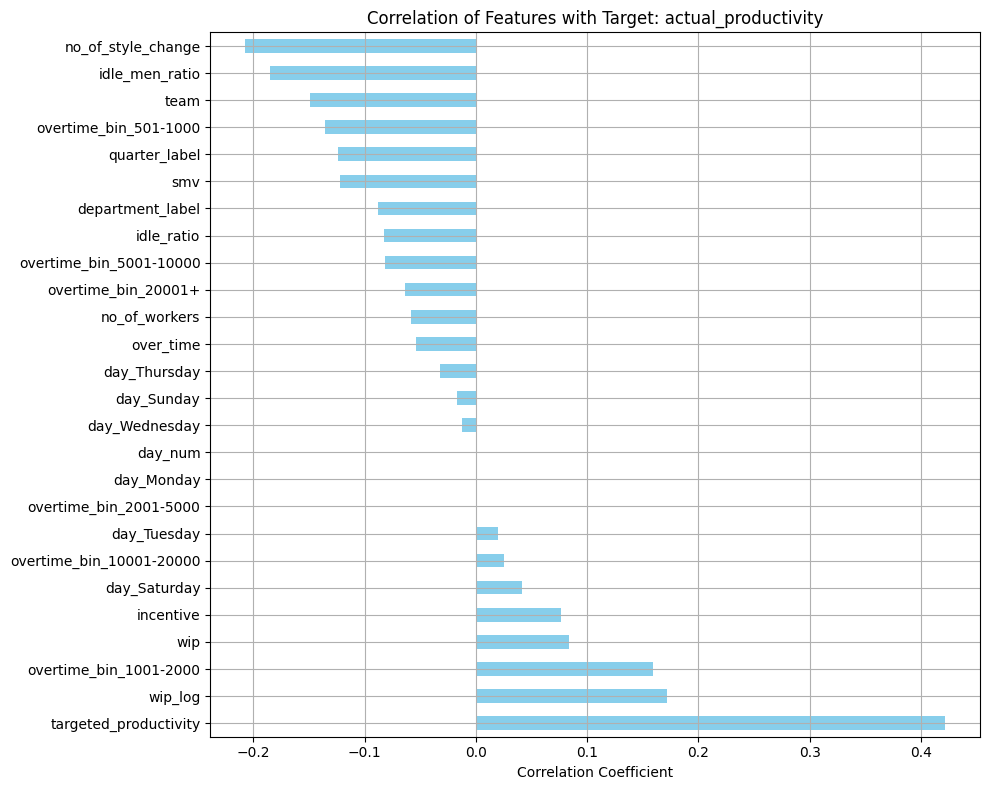

In [74]:
 # Creating a correlation matrix for this data set 
correlation_matrix = df.corr(numeric_only=True)
target_corr = correlation_matrix['actual_productivity'].drop('actual_productivity')
target_corr_sorted = target_corr.sort_values(ascending=False)

# Plotting the figure for correlation of features
plt.figure(figsize=(10, 8))
target_corr_sorted.plot(kind='barh', color='skyblue')
plt.title("Correlation of Features with Target: actual_productivity")
plt.xlabel("Correlation Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

### Correlation Analysis with Target Variable (time_to_resolution_log)

* targeted_productivity shows the strongest positive correlation (~0.41) with actual_productivity, suggesting it is a key predictive feature and aligns well with operational expectations.

Other features with mild positive correlation include:

* wip_log (~0.18)

* overtime_bin_1001-2000 and wip (~0.15–0.17)

* incentive, day_Saturday, and overtime_bin_10001-20000 show weak but positive associations, suggesting potential minor contributions to productivity.

* Features like day_Tuesday, day_Monday, day_num, and other weekday indicators appear negligibly correlated, indicating low linear impact from daily cycles.

* Features such as over_time, no_of_workers, and department_label are very weakly or negatively correlated, implying limited standalone predictive power in a linear model.

* Notably, variables like:

   * team, idle_men_ratio, and no_of_style_change show moderate negative correlations (up to -0.21),   possibly suggesting efficiency loss due to idle   time, task switching, or organizational factors.

#### Now our target variable is ready for the SVR modeling 

In [75]:
# Defining features and target
X = df.drop(columns=["actual_productivity"])
y = df["actual_productivity"]

In [76]:
# Train-test spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [77]:
# Defining and tuning the SVR
param_grid = {
    "C": [0.1, 1, 10, 50],
    "epsilon": [0.01, 0.05, 0.1, 0.2],
    "kernel": ["rbf"]
}

grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 50],
                         'epsilon': [0.01, 0.05, 0.1, 0.2], 'kernel': ['rbf']},
             scoring='neg_root_mean_squared_error')

In [78]:
# Showing best parameters
print("Best Parameters Found:")
print(grid_search.best_params_)

Best Parameters Found:
{'C': 50, 'epsilon': 0.1, 'kernel': 'rbf'}


In [79]:
# Defining and training final SVR model with best parameters
final_svr = SVR(
    C=50,
    epsilon=0.1,
    kernel='rbf'
)

final_svr.fit(X_train, y_train)

SVR(C=50)

In [80]:
# Making predictions on test set
y_pred = final_svr.predict(X_test)

# Evaluating model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 4. Print evaluation metrics
print("\nModel Evaluation Metrics (SVR):")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


Model Evaluation Metrics (SVR):
MAE  : 0.1113
RMSE : 0.1463
R²   : 0.1942


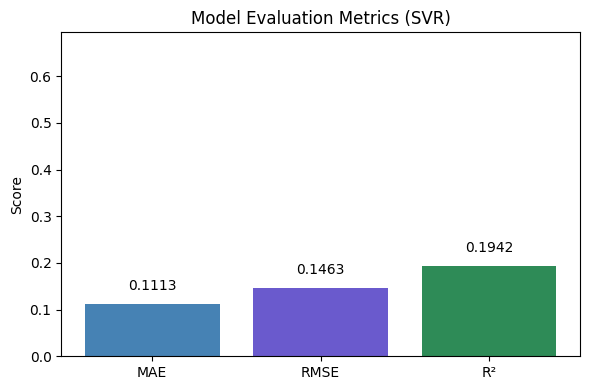

In [81]:
# Defining metrics
metrics = ['MAE', 'RMSE', 'R²']
values = [0.1113, 0.1463, 0.1942]

# Creating bar plot
plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['steelblue', 'slateblue', 'seagreen'])

# Annotation of values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.03, f'{height:.4f}', ha='center', fontsize=10)

plt.title("Model Evaluation Metrics (SVR)")
plt.ylabel("Score")
plt.ylim(0, max(values) + 0.5)
plt.tight_layout()
plt.show()

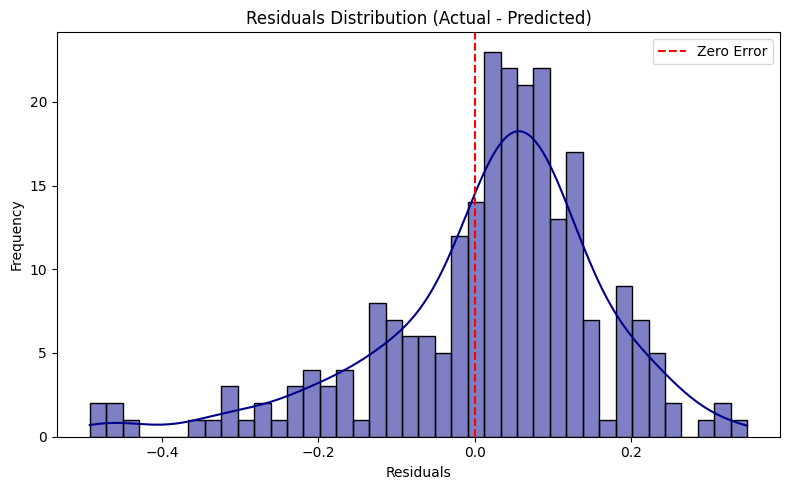

In [82]:
 # Calculating residuals
residuals = y_test - y_pred

# Ploting histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True, color='darkblue')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.title("Residuals Distribution (Actual - Predicted)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

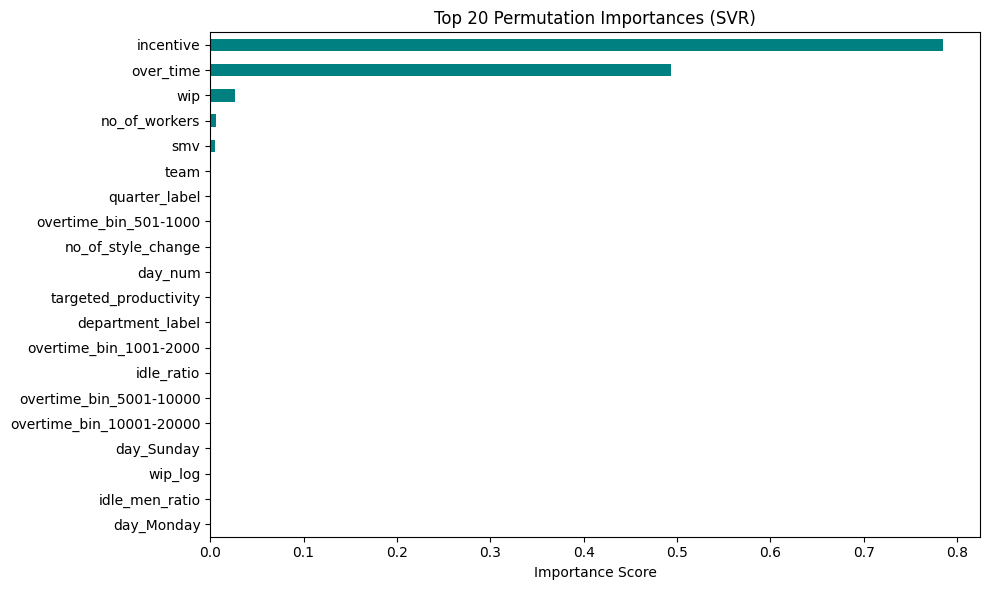

In [83]:
# Creating the importance DataFrame
perm_result = permutation_importance(final_svr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances = pd.Series(perm_result.importances_mean, index=X_test.columns).sort_values(ascending=False)

# Ploting top 20 important features 
plt.figure(figsize=(10, 6))
perm_importances[:20].plot(kind='barh', color='teal')
plt.title("Top 20 Permutation Importances (SVR)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()